<a href="https://colab.research.google.com/github/bartdob/ML/blob/master/CovidPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from keras.layers import LSTM
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import io
import requests
import urllib.request as urllib2
df = pd.read_csv('https://pythondjango-myapp.herokuapp.com/covid/covid.csv/')
confirmed = df["Today_new_confirmed"]
date1 = df["Date"]
df.head(1000)

,Date,Confirmed,Recovered,Critical,Deaths,Today_new_deaths,Today_new_confirmed
0,2020-12-02 00:00:00+00:00,1013747,622980,2023,18208,609,13823
1,2020-11-27 00:00:00+00:00,958416,516636,2106,16147,579,17100
2,2020-11-08 00:00:00+00:00,546425,209363,1841,7872,236,24785
3,2021-02-10 00:00:00+00:00,1385522,1123318,1602,31189,361,6960
4,2020-12-03 00:00:00+00:00,1028610,646560,1986,18828,620,14863
...,...,...,...,...,...,...,...
243,2021-10-23 00:00:00+00:00,2968200,2683645,399,76434,0,0
244,2021-10-24 00:00:00+00:00,2972927,2686129,430,76447,13,4727
245,2021-10-25 00:00:00+00:00,2975880,2688899,444,76447,0,2953
246,2021-10-26 00:00:00+00:00,2982143,2690118,449,76540,93,6263


[13823, 17100, 24785, 6960, 14863, 13236, 8310, 16300, 18820, 21713, 20156, 21629, 25221, 25500, 21897, 24051, 12166, 25571, 22700, 13200, 9200, 19152, 5176, 8699, 19883, 17171, 9074, 13750, 15578, 23975, 22464, 17856, 15002, 32733, 7040, 13105, 16690, 15400, 3891, 15177, 24692, 8976, 11482, 5736, 27143, 4633, 4878, 9113, 6304, 27086, 12147, 4863, 5394, 12430, 11499, 27875, 4896, 4896, 7624, 5970, 3332, 6943, 6693, 2674, 4603, 4711, 4786, 14579, 30802, 7914, 6802, 6379, 8246, 2543, 8777, 12124, 1099, 20862, 26045, 34150, 2296, 35145, 12151, 32891, 31759, 29266, 27890, 35251, 28499, 16965, 30546, 28073, 21703, 12016, 22958, 9921, 7302, 15786, 10866, 5711, 6047, 2031, 3097, 1734, 3252, 943, 333, 585, 659, 192, 401, 24856, 4255, 8895, 2344, 3896, 560, 226, 103, 124, 215, 190, 168, 133, 73, 14910, 405, 9246, 211, 164, 122, 190, 108, 162, 148, 144, 134, 203, 99, 128, 80, 51, 176, 215, 74, 122, 531, 98, 207, 107, 97, 108, 55, 196, 138, 95, 100, 172, 93, 165, 66, 94, 87, 105, 90, 212, 114, 69

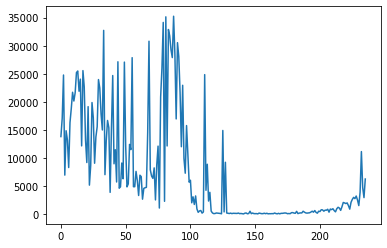

In [ ]:
conf = []
for i in confirmed:
  if i != 0:
    conf.append(i)

print(conf)

sns.lineplot(data=conf)


    



In [ ]:
#predicition

Epoch 1/150
3/3 - 2s - loss: 0.0407 - val_loss: 4.9056e-05
Epoch 2/150
3/3 - 0s - loss: 0.0349 - val_loss: 2.3257e-04
Epoch 3/150
3/3 - 0s - loss: 0.0314 - val_loss: 5.5067e-04
Epoch 4/150
3/3 - 0s - loss: 0.0319 - val_loss: 9.7256e-04
Epoch 5/150
3/3 - 0s - loss: 0.0344 - val_loss: 0.0014
Epoch 6/150
3/3 - 0s - loss: 0.0325 - val_loss: 0.0020
Epoch 7/150
3/3 - 0s - loss: 0.0309 - val_loss: 0.0025
Epoch 8/150
3/3 - 0s - loss: 0.0326 - val_loss: 0.0028
Epoch 9/150
3/3 - 0s - loss: 0.0288 - val_loss: 0.0031
Epoch 10/150
3/3 - 0s - loss: 0.0342 - val_loss: 0.0031
Epoch 00010: early stopping
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_____________________________________________________

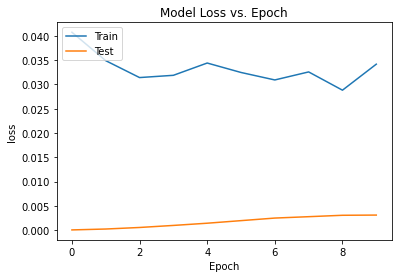

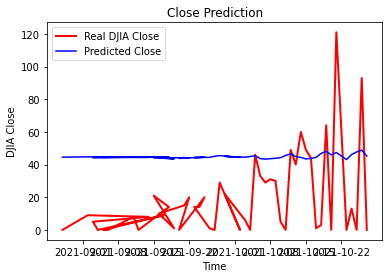

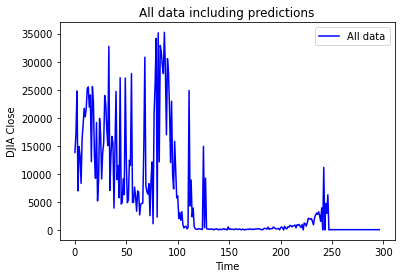

ValueError: ignored

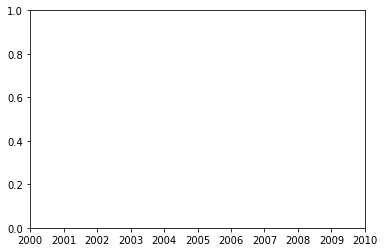

In [ ]:
close_data = df['Today_new_confirmed'] # 1D (examples, )
dates = df['Date'] # 1D (examples, )
adj_dates = mdates.datestr2num(dates) # Convert Pandas series to np array so matplotlib can plot

# Important parameter
sequence_length: int = 100 # Aka 'timesteps', or number of close values used to make each new prediction

# Split off the training set and scale it. 
percent_training: float = 0.80
num_training_samples = math.ceil(percent_training*len(df)) # A whole number
training_set = df.iloc[:num_training_samples, 5:6].values # 2D, shape: (samples, 1 feature)
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set) #Shape is 2D: (num_training_samples, 1)

# Build 3D training set. Final shape: (examples, sequence_length, 1) 
x_train = np.array([training_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(training_set_scaled))]) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build test sets
num_testing_samples: int = len(df) - x_train.shape[0] # Scalar value
testing_set = df.iloc[-num_testing_samples:, 5:6].values # 2D (examples, 1)
testing_set_scaled = scaler.fit_transform(testing_set) # 2D ndarray (examples, 1)

x_test = np.array([testing_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(testing_set_scaled))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #3D shape: (examples-sequence_length, sequence_length, 1). 

# Build 1D training labels (examples, )
y_train = np.array([training_set_scaled[i, 0] for i in range(sequence_length, len(training_set_scaled))])
y_test = np.array([testing_set_scaled[i, 0] for i in range(sequence_length, len(testing_set_scaled))]) # (examples-sequence_length, 1)
y_test = np.reshape(y_test, (y_test.shape[0])) #1D (examples, )

# Build Model
epochs: int = 150
batch_size: int = 32

LSTM_1 = LSTM(
    units = 5, # I reduced model complexity because I thought it would reduce overfitting. No such luck
    input_shape = (x_train.shape[1], 1),
    return_sequences = False,
    )

LSTM_2 = LSTM(
    units = 10
    )

model = Sequential()
model.add(LSTM_1) # Output shape: (batch_size, sequence_length, units)
model.add(Dropout(0.4))
# model.add(LSTM_2) # Output shape: ?
# model.add(Dropout(0.2))

model.add(Dense(1)) # Is linear activation appropriate here?
model.compile(loss = 'mean_squared_error', 
             optimizer = 'adam', 
             )

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 9,
                               restore_best_weights = False
                               )

history = model.fit(x_train,
          y_train,
          epochs = epochs, 
          batch_size = batch_size,
          verbose = 2, 
          validation_split = 0.20,
          # validation_data = (x_test, y_test),
          callbacks = [early_stopping],
          )

# Evaluate performance 
model.summary()
loss = model.evaluate(x_test, y_test, batch_size = batch_size)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

y_test2 = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test2)

test_dates = adj_dates[-x_test.shape[0]:]

# Visualizing the results
plt.plot_date(test_dates, y_test, '-', linewidth = 2, color = 'red', label = 'Real DJIA Close')
plt.plot(test_dates, prediction, color = 'blue', label = 'Predicted Close')
plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('DJIA Close')
plt.legend()
plt.show()

# Generate future data 
time_horizon = sequence_length
# future_lookback = adj_dates[-time_horizon:]

last_n = x_test[-time_horizon:,:,:] # Find last n number of days
future_prediction = model.predict(last_n)
future_prediction2 = np.reshape(future_prediction, (future_prediction.shape[0], 1))
future_prediction3 = scaler.inverse_transform(future_prediction2)
future_prediction3 = np.reshape(future_prediction3, (future_prediction3.shape[0]))
 
full_dataset_numpy = np.array(close_data)
all_data = np.append(full_dataset_numpy, future_prediction3)
plt.plot(all_data, color = 'blue', label = 'All data')
plt.title('All data including predictions')
plt.xlabel('Time')
plt.ylabel('DJIA Close')
plt.legend()
plt.show()

# Generate dates for future predictions
# Begin at the last date in the dataset, then add 'time_horizon' many new dates
last_date = dates.iloc[-1] # String
timestamp_list = pd.date_range(last_date, periods = time_horizon).tolist() #List of timestamps

# Convert list of timestamps to list of strings 
datestring_list = [i.strftime("%m-%d") for i in timestamp_list] #List of strings

# Clip first value, which is already included in the dataset
datestring2 = mdates.datestr2num(datestring_list)

plt.plot_date(datestring2, future_prediction3, '-', color = 'blue', label = 'Predicted Close')
plt.title('DJIA Close Prediction')
plt.xlabel('Date')
plt.ylabel('Predicted Close')
plt.xticks(rotation = 45)
plt.legend()
plt.show()
